# (22) ca awake -- affine (draft)

**Motivation**: See if rigid transforms work. This is a draft notebook to explore possibilities. Maybe follow that up with affine? <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def _invert_lr(img, arr=None):
    if arr is None:
        arr = img.numpy()
    return reset_ants_img(
        img=arr[:, ::-1],
        spacing=img.spacing,
        origin=img.origin,
        dtype=img.dtype,
        use_um=False,
    )


def _load_fx(sub: int, sharp_mask: bool = False):
    fx = f'sub-SLC{sub:02d}_ses-4_space-individual_desc-referenceimage_ca2.nii.gz'
    fx = ants.image_read(pjoin(mice.cfg.raw_dir, fx))
    fx = _invert_lr(fx)
    m_fx = f'sub-SLC{sub:02d}_ses-4_space-individual_desc-mask_ca2.nii.gz'
    m_fx = ants.image_read(pjoin(mice.cfg.raw_dir, m_fx))
    m_fx = _invert_lr(
        img=m_fx,
        arr=m_fx.numpy() == 1.0 if
        sharp_mask else m_fx.numpy()
    )
    return fx, m_fx


def _load_mv(sub: int, ses: int, sharp_mask: bool = False):
    mv = f'sub-SLC{sub:02d}_ses-{ses}_space-individual_desc-referenceimage_ca2.nii.gz'
    mv = ants.image_read(pjoin(mice.cfg.raw_dir, mv))
    mv = reset_ants_img(
        img=mv.numpy()[..., 0],
        spacing=mv.spacing[:2],
        origin=mv.origin[:2],
        dtype=mv.dtype,
        use_um=False,
    )
    m_mv = f'sub-SLC{sub:02d}_ses-{ses}_space-individual_desc-mask_ca2.nii.gz'
    m_mv = ants.image_read(pjoin(mice.cfg.raw_dir, m_mv))
    m_mv = reset_ants_img(
        img=rescale(
            m_mv.numpy() == 1.0 if
            sharp_mask else m_mv.numpy(), 2),
        spacing=mv.spacing,
        origin=mv.origin,
        dtype=mv.dtype,
        use_um=False,
    )
    return mv, m_mv


def _load_obj(sub: int, ses: int, obj: str = 'cols'):
    mv, _ = _load_mv(sub, ses)
    obj = f'sub-SLC{sub:02d}_ses-{ses}_space-indiv2d_{obj}.nii.gz'
    obj = ants.image_read(pjoin(mice.cfg.masks_dir, obj))
    obj = reset_ants_img(
        img=obj.numpy()[..., 0],
        spacing=mv.spacing,
        origin=mv.origin,
        dtype='uint32',
        use_um=False,
    )
    return obj


def _show_ref_overlay(x, mask, overlay, bound: int = 512):
    m = mask.numpy()
    x2p = filter_boundaries(x.numpy() * m, m)
    
    fig, axes = create_figure(1, 3, (7.8, 3.0), 'all', 'all', 'constrained')
    remove_ticks(axes)
    for ax in axes.flat:
        ax.imshow(x2p, cmap='Greys_r')

    axes[1].set_title('left hemis')
    axes[2].set_title('right hemis')

    x2p = filter_boundaries(overlay.numpy(), m)
    x2p = mwh(~np.logical_and(1 < x2p, x2p < bound), x2p)
    axes[1].imshow(x2p, cmap='Spectral', interpolation='none')

    x2p = filter_boundaries(overlay.numpy(), m)
    x2p = mwh(x2p < bound, x2p)
    axes[2].imshow(x2p, cmap='Spectral', interpolation='none')

    plt.show()


def _show_ref(sub):
    fx, m_fx = _load_fx(sub)

    fig, axes = create_figure(2, 2, (7, 7), 'all', 'all', 'constrained')
    ax = axes.flat[-1]
    ax.set_title("awake")
    x2p = mwh(~m_fx.numpy().astype(bool), fx.numpy())
    ax.imshow(x2p, cmap='Greys_r')

    for i in range(3):
        ax = axes.flat[i]
        ax.set_title(f"ses-{i+1}")
        mv, m_mv  = _load_mv(sub, i + 1)
        x2p = mwh(~m_mv.numpy().astype(bool), mv.numpy())
        ax.imshow(x2p, cmap='Greys_r')

    plt.show()

    
def _get_op(sub):
    if sub in [2, 6]:
        def _op(img, arr=None):
            if arr is None:
                arr = img.numpy()
            #############################
            arr = arr.T
            arr = arr[::-1]
            #############################
            return reset_ants_img(
                img=arr,
                spacing=img.spacing,
                origin=img.origin,
                dtype=img.dtype,
                use_um=False,
            )
    else:
        return
    return _op


def _fit_rigid(sub: int, n_seeds: int = 20, verbose: bool = True):
    fx, m_fx = _load_fx(sub)
    mi_base = ants.image_mutual_information(
        image1=fx * m_fx, image2=fx * m_fx)
    op = _get_op(sub)
    df = []
    best_tx = None
    best_mi = -np.inf
    best_ses = None
    pbar1 = tqdm(
        range(1, 3 + 1),
        disable=not verbose,
        leave=True,
    )
    for ses in pbar1:
        mv, m_mv = _load_mv(sub, ses)
        if op is not None:
            mv, m_mv = map(op, [mv, m_mv])
        pbar2 = tqdm(
            range(n_seeds),
            disable=not verbose,
            leave=False,
        )
        for seed in pbar2:
            _tx = ants.registration(
                fixed=fx * m_fx,
                moving=mv * m_mv,
                type_of_transform='DenseRigid',
                random_seed=seed,
            )
            mi = ants.image_mutual_information(
                image1=fx * m_fx,
                image2=_tx['warpedmovout'],
            ) / mi_base
            df.append({
                'sub': [sub],
                'ses': [ses],
                'seed': [seed],
                'mi': [mi],
            })
            if mi > best_mi:
                best_mi = mi
                best_tx = _tx.copy()
                best_ses = ses
    df = pd.DataFrame(merge_dicts(df))
    assert df.iloc[df['mi'].argmax()]['mi'] == best_mi
    return best_ses, best_tx, df


def _fit_affine(
    fixed: ants.ANTsImage,
    moving: ants.ANTsImage,
    t_type: str = 'Similarity',
    n_seeds: int = 20,
    verbose: bool = True, ):
    mi_base = ants.image_mutual_information(
        image1=fixed, image2=fixed)

    best_tx = None
    best_mi = -np.inf
    pbar = tqdm(
        range(n_seeds),
        disable=not verbose,
        leave=True,
    )
    for seed in pbar:
        _tx = ants.registration(
            fixed=fixed,
            moving=moving,
            type_of_transform=t_type,
            random_seed=seed,
        )
        mi = ants.image_mutual_information(
            image1=fixed,
            image2=_tx['warpedmovout'],
        ) / mi_base
        if mi > best_mi:
            best_mi = mi
            best_tx = _tx.copy()
    return best_tx, best_mi


from register.register import reset_ants_img
from skimage.transform import rescale, resize

In [3]:
mice = Mice(512)

## Which subs

In [4]:
files = sorted(filter(
    lambda s: 'awake' in s,
    os.listdir(mice.cfg.raw_dir),
))
subs = [
    int(re.findall(r'\d+', f.split('_')[0]).pop())
    for f in files
]
subs = [
    k for k, v in collections.Counter(subs).items()
    if k <= 10 and v >= 9
]
subs

[2, 6, 7, 9, 10]

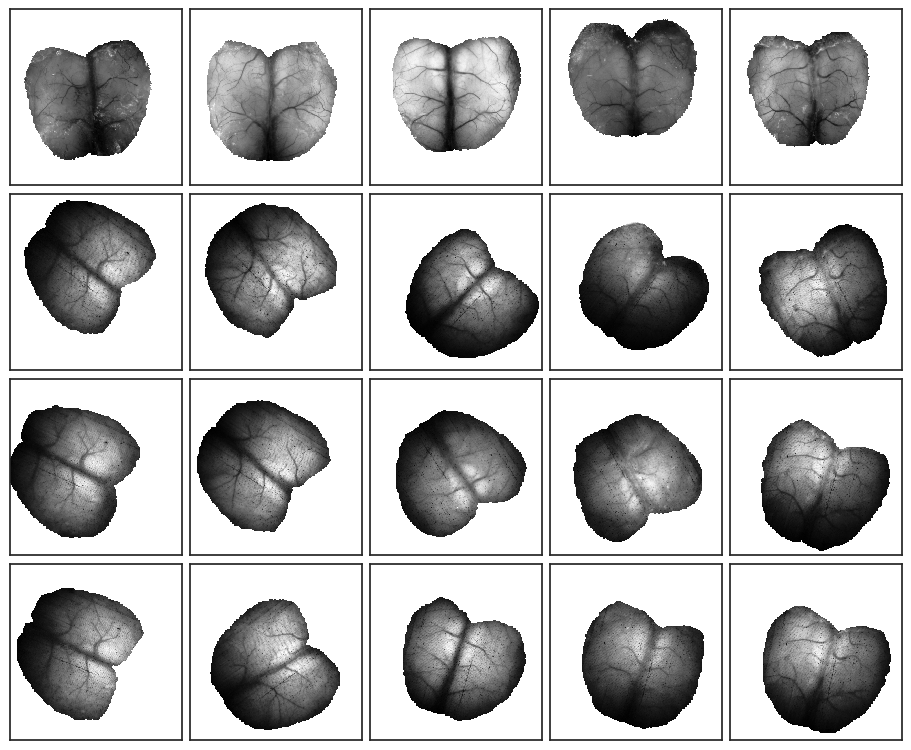

In [5]:
fig, axes = create_figure(4, len(subs), (9, 7.4), layout='constrained')
for i in range(4):
    for j, sub in enumerate(subs):
        if i == 0:
            x, m = _load_fx(sub)
        else:
            x, m = _load_mv(sub, i)
        ax = axes[i, j]
        x2p = mwh(m.numpy() == 0, x.numpy())
        ax.imshow(x2p, cmap='Greys_r')
remove_ticks(axes, False)
plt.show()

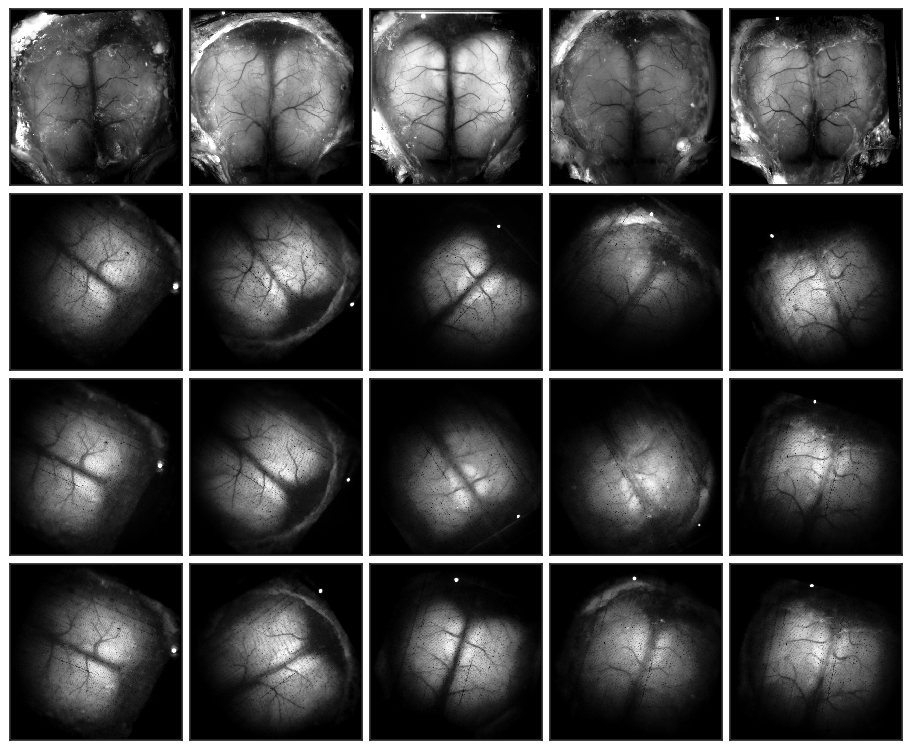

In [6]:
fig, axes = create_figure(4, len(subs), (9, 7.4), layout='constrained')
for i in range(4):
    for j, sub in enumerate(subs):
        if i == 0:
            x, m = _load_fx(sub)
        else:
            x, m = _load_mv(sub, i)
        x = x.numpy()
        m = m.numpy()
        vmin = np.nanmin(x[m > 0])
        vmax = np.nanmax(x[m > 0])
        ax = axes[i, j]
        ax.imshow(x, vmin=vmin, vmax=vmax, cmap='Greys_r')
remove_ticks(axes, False)
plt.show()

## Check out some ref images

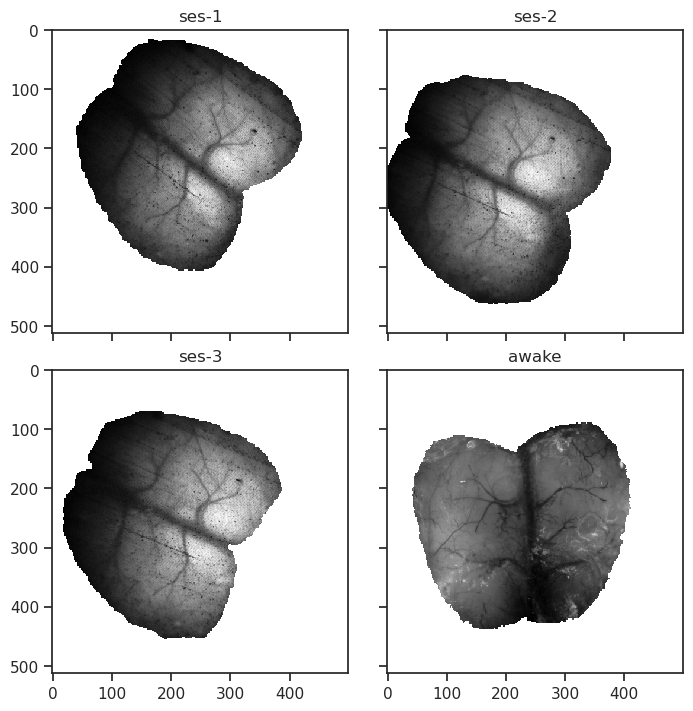

In [7]:
_show_ref(2)

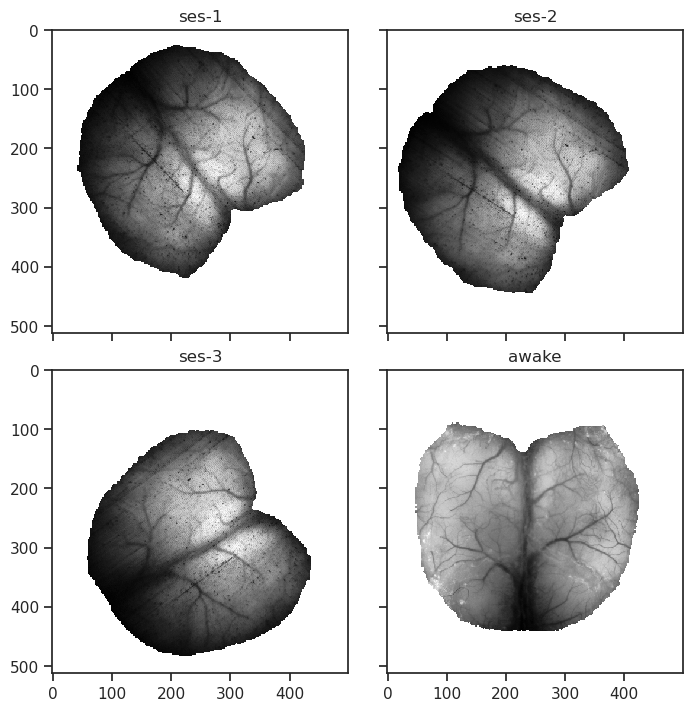

In [8]:
_show_ref(6)

## Rigid

In [9]:
subs

[2, 6, 7, 9, 10]

### Sub = 2

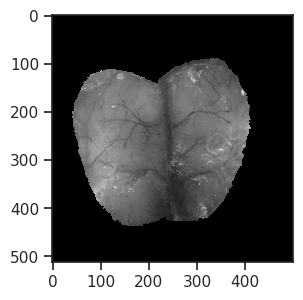

In [11]:
sub = 2
fx, m_fx = _load_fx(sub)
plt.imshow((fx * m_fx).numpy(), cmap='Greys_r');

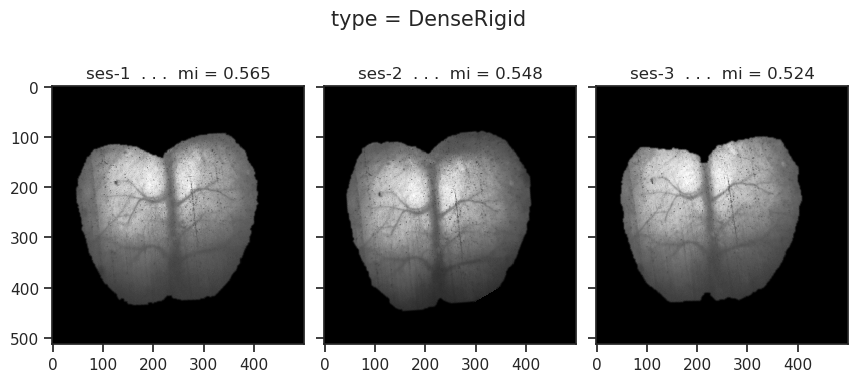

In [12]:
mi_base = ants.image_mutual_information(
    image1=fx * m_fx, image2=fx * m_fx)

fig, axes = create_figure(1, 3, (8.5, 3), 'all', 'all', 'constrained')
_t = 'DenseRigid'

for i, ax in enumerate(axes.flat):
    mv, m_mv = _load_mv(sub, i + 1)
    mv, m_mv = map(_get_op(sub), [mv, m_mv])
    tx = ants.registration(
        fixed=fx * m_fx,
        moving=mv * m_mv,
        type_of_transform=_t,
        random_seed=0,
    )
    mi = ants.image_mutual_information(
        image1=fx * m_fx, image2=tx['warpedmovout'])
    ax.imshow(tx['warpedmovout'].numpy(), cmap='Greys_r')
    ax.set_title(f"ses-{i+1}  . . .  mi = {mi / mi_base:0.3f}")
fig.suptitle(f"type = {_t}", y=1.2, fontsize=15)
plt.show()

### Sub = 6

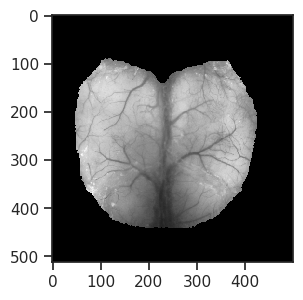

In [13]:
sub = 6
fx, m_fx = _load_fx(sub)
plt.imshow((fx * m_fx).numpy(), cmap='Greys_r');

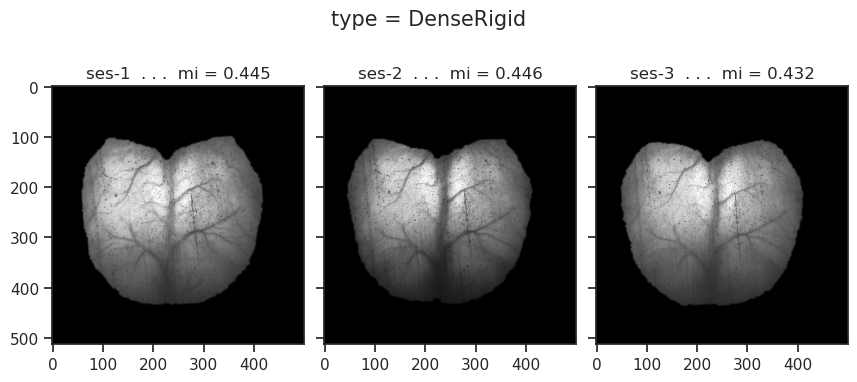

In [14]:
mi_base = ants.image_mutual_information(
    image1=fx * m_fx, image2=fx * m_fx)

fig, axes = create_figure(1, 3, (8.5, 3), 'all', 'all', 'constrained')
_t = 'DenseRigid'

for i, ax in enumerate(axes.flat):
    mv, m_mv = _load_mv(sub, i + 1)
    mv, m_mv = map(_get_op(sub), [mv, m_mv])
    tx = ants.registration(
        fixed=fx * m_fx,
        moving=mv * m_mv,
        type_of_transform=_t,
        random_seed=0,
    )
    mi = ants.image_mutual_information(
        image1=fx * m_fx, image2=tx['warpedmovout'])
    ax.imshow(tx['warpedmovout'].numpy(), cmap='Greys_r')
    ax.set_title(f"ses-{i+1}  . . .  mi = {mi / mi_base:0.3f}")
fig.suptitle(f"type = {_t}", y=1.2, fontsize=15)
plt.show()

## Rigid + ...?

In [19]:
sub, ses = 2, 1
fx, m_fx = _load_fx(sub)
mv, m_mv = _load_mv(sub, ses)
cols = _load_obj(sub, ses)

op = _get_op(sub)
if op is not None:
    mv, m_mv, cols = map(op, [mv, m_mv, cols])

cols

ANTsImage
         Pixel Type : unsigned int (uint32)
         Components : 1
         Dimensions : (500, 512)
         Spacing    : (0.025, 0.025)
         Origin     : (0.0, 0.0)
         Direction  : [1. 0. 0. 1.]

In [20]:
mi_base = ants.image_mutual_information(
    image1=fx * m_fx, image2=fx * m_fx)

In [21]:
tx_rigid = ants.registration(
    fixed=fx * m_fx,
    moving=mv * m_mv,
    type_of_transform='DenseRigid',
    random_seed=0,
)
mi = ants.image_mutual_information(
    image1=fx * m_fx, image2=tx_rigid['warpedmovout'])
mi / mi_base

0.5647978449862109

In [22]:
cols_rig = ants.apply_transforms(
    fixed=fx * m_fx,
    moving=cols,
    transformlist=tx_rigid['fwdtransforms'],
    interpolator='genericLabel',
)

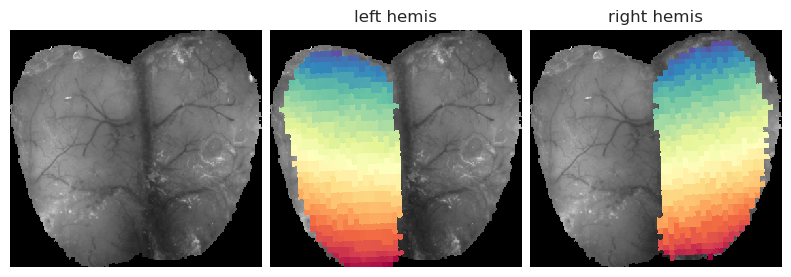

In [23]:
_show_ref_overlay(fx, m_fx, cols_rig)

In [24]:
tx_aff = ants.registration(
    fixed=fx * m_fx,
    moving=tx_rigid['warpedmovout'],
    type_of_transform='Similarity',
    random_seed=0,
)
mi = ants.image_mutual_information(
    image1=fx * m_fx, image2=tx_aff['warpedmovout'])
mi / mi_base

0.6015908753081042

In [25]:
cols_aff = ants.apply_transforms(
    fixed=fx * m_fx,
    moving=cols_rig,
    transformlist=tx_aff['fwdtransforms'],
    interpolator='genericLabel',
)

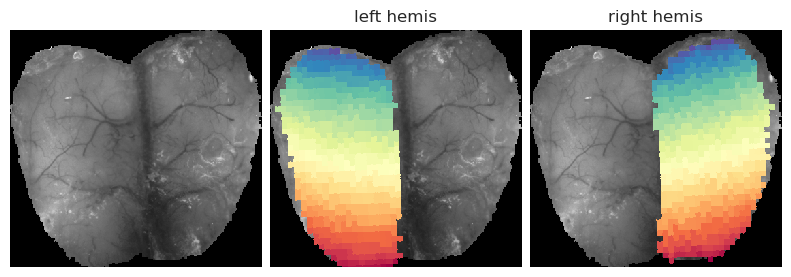

In [26]:
_show_ref_overlay(fx, m_fx, cols_aff)

## Rigid + {Similarity, Affine, etc}?

### Test on sub 2

In [28]:
%%time

sub = 2
fx, m_fx = _load_fx(sub)
best_ses, best_tx_rigid, df_rigid = _fit_rigid(sub)
best_tx_aff, best_mi = _fit_affine(
    fixed=fx * m_fx,
    moving=best_tx_rigid['warpedmovout'],
    t_type='Similarity',
)
best_mi

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 39min 19s, sys: 1min 49s, total: 41min 8s
Wall time: 2min 33s


0.6015940450249907

In [29]:
cols = _load_obj(sub, best_ses)
op = _get_op(sub)
if op is not None:
    cols = op(cols)

cols_rig = ants.apply_transforms(
    fixed=fx * m_fx,
    moving=cols,
    transformlist=best_tx_rigid['fwdtransforms'],
    interpolator='genericLabel',
)
cols_aff = ants.apply_transforms(
    fixed=fx * m_fx,
    moving=cols_rig,
    transformlist=best_tx_aff['fwdtransforms'],
    interpolator='genericLabel',
)

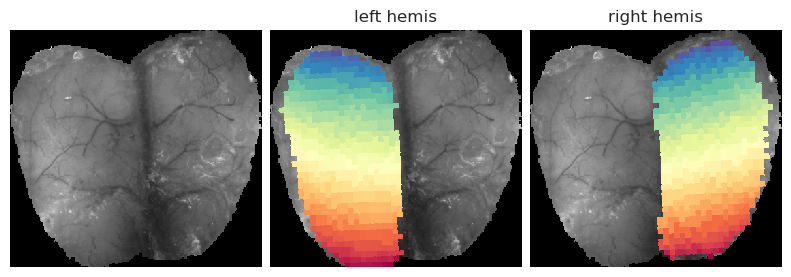

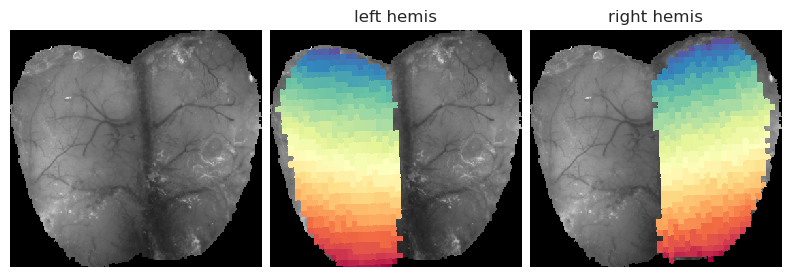

In [30]:
_show_ref_overlay(fx, m_fx, cols_rig)
_show_ref_overlay(fx, m_fx, cols_aff)

type: Similarity,  mi = 0.6016

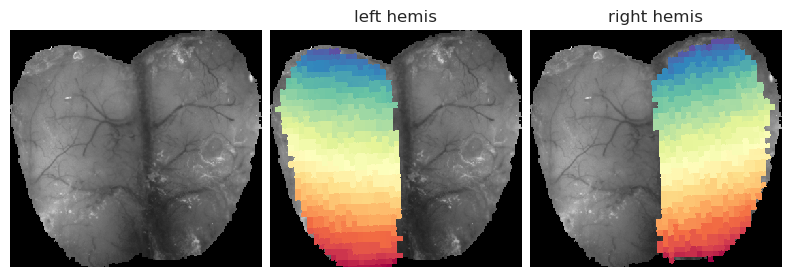

type: Affine,  mi = 0.6016

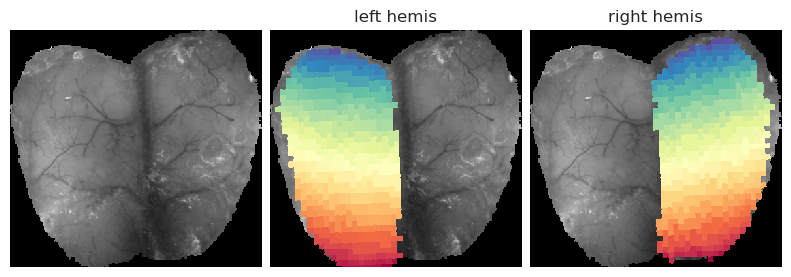

type: ElasticSyN,  mi = 0.6160

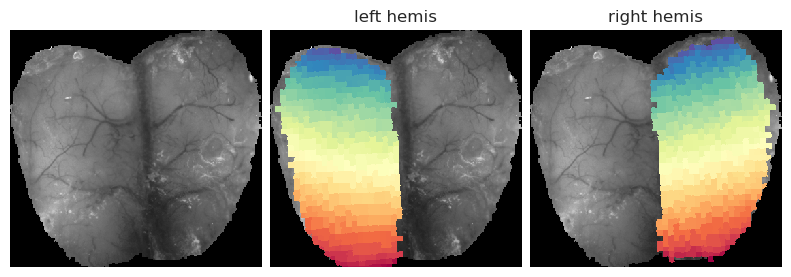

type: SyNAggro,  mi = 0.6158

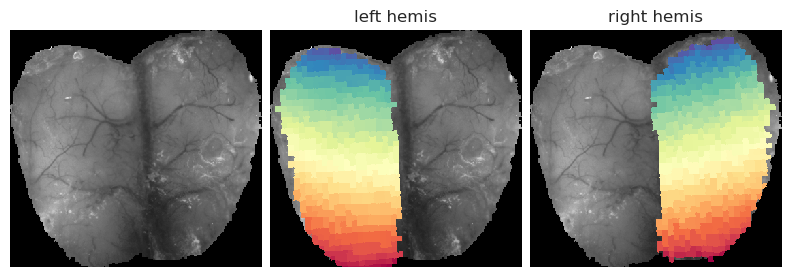

In [31]:
for t_type in ['Similarity', 'Affine', 'ElasticSyN', 'SyNAggro']:
    best_tx_aff, best_mi = _fit_affine(
        fixed=fx * m_fx,
        moving=best_tx_rigid['warpedmovout'],
        t_type=t_type,
        verbose=False,
    )
    cols_aff = ants.apply_transforms(
        fixed=fx * m_fx,
        moving=cols_rig,
        transformlist=best_tx_aff['fwdtransforms'],
        interpolator='genericLabel',
    )
    print(f"type: {t_type},  mi = {best_mi:0.4f}")
    _show_ref_overlay(fx, m_fx, cols_aff)

## Test for all subjects

In [33]:
%%time

df = []
cols_aff = collections.defaultdict(dict)
for sub in subs:
    op = _get_op(sub)
    fx, m_fx = _load_fx(sub)
    best_ses, best_tx_rigid, _ = _fit_rigid(
        sub=sub, verbose=False)
    cols = _load_obj(sub, best_ses)
    cols_rig = ants.apply_transforms(
        fixed=fx * m_fx,
        moving=cols if op is None else op(cols),
        transformlist=best_tx_rigid['fwdtransforms'],
        interpolator='genericLabel',
    )
    for t_type in ['Similarity', 'Affine', 'ElasticSyN', 'SyNAggro']:
        best_tx_aff, best_mi = _fit_affine(
            fixed=fx * m_fx,
            moving=best_tx_rigid['warpedmovout'],
            t_type=t_type,
            verbose=False,
        )
        cols_aff[sub][t_type] = ants.apply_transforms(
            fixed=fx * m_fx,
            moving=cols_rig,
            transformlist=best_tx_aff['fwdtransforms'],
            interpolator='genericLabel',
        )
        df.append({
            'sub': [sub],
            'ses': [best_ses],
            't_type': [t_type],
            'mi': [best_mi],
        })
df = pd.DataFrame(merge_dicts(df))

CPU times: user 5h 27min 13s, sys: 27min 46s, total: 5h 54min 59s
Wall time: 27min 36s


In [34]:
df

sub 
 ses 
 t_type 
 mi 
 
 
 
 
 0 
 2 
 1 
 Similarity 
 0.601569 
 
 
 1 
 2 
 1 
 Affine 
 0.601540 
 
 
 2 
 2 
 1 
 ElasticSyN 
 0.617278 
 
 
 3 
 2 
 1 
 SyNAggro 
 0.615703 
 
 
 4 
 6 
 2 
 Similarity 
 0.526776 
 
 
 5 
 6 
 2 
 Affine 
 0.531896 
 
 
 6 
 6 
 2 
 ElasticSyN 
 0.593574 
 
 
 7 
 6 
 2 
 SyNAggro 
 0.593176 
 
 
 8 
 7 
 1 
 Similarity 
 0.543908 
 
 
 9 
 7 
 1 
 Affine 
 0.544232 
 
 
 10 
 7 
 1 
 ElasticSyN 
 0.574501 
 
 
 11 
 7 
 1 
 SyNAggro 
 0.573669 
 
 
 12 
 9 
 1 
 Similarity 
 0.622115 
 
 
 13 
 9 
 1 
 Affine 
 0.622093 
 
 
 14 
 9 
 1 
 ElasticSyN 
 0.628179 
 
 
 15 
 9 
 1 
 SyNAggro 
 0.628140 
 
 
 16 
 10 
 1 
 Similarity 
 0.626649 
 
 
 17 
 10 
 1 
 Affine 
 0.626709 
 
 
 18 
 10 
 1 
 ElasticSyN 
 0.646454 
 
 
 19 
 10 
 1 
 SyNAggro 
 0.646399

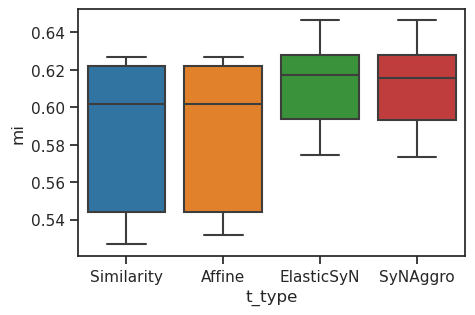

In [35]:
sns.boxplot(data=df, x='t_type', y='mi');

sub 02,  type: Similarity,   mi = 0.6016

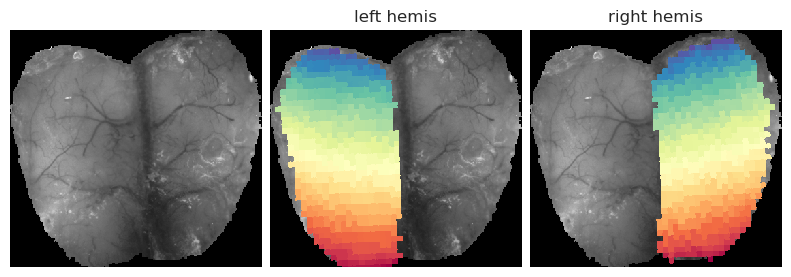

sub 02,  type: Affine,   mi = 0.6015

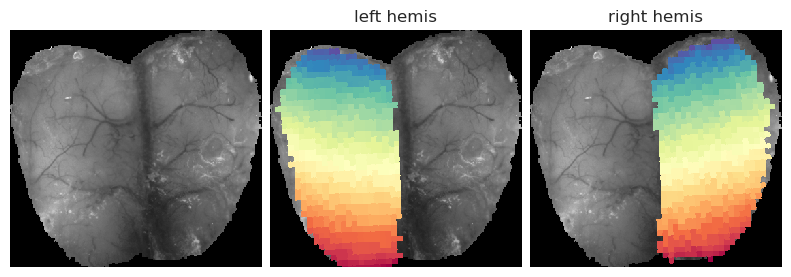

sub 02,  type: ElasticSyN,   mi = 0.6173

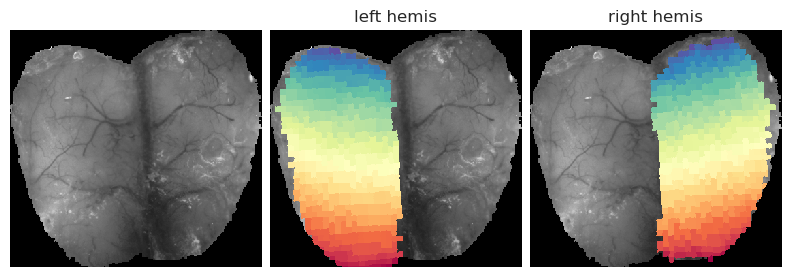

sub 02,  type: SyNAggro,   mi = 0.6157

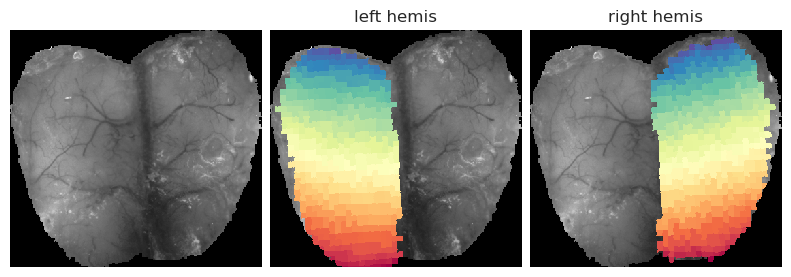

sub 06,  type: Similarity,   mi = 0.5268

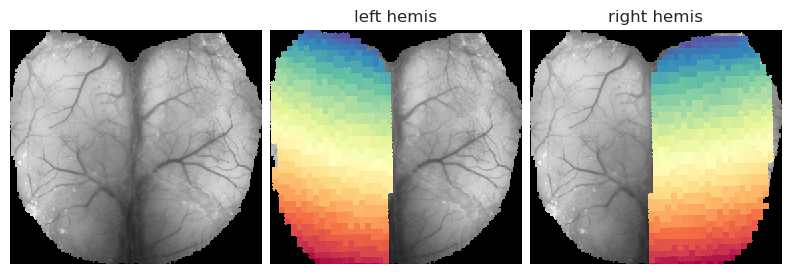

sub 06,  type: Affine,   mi = 0.5319

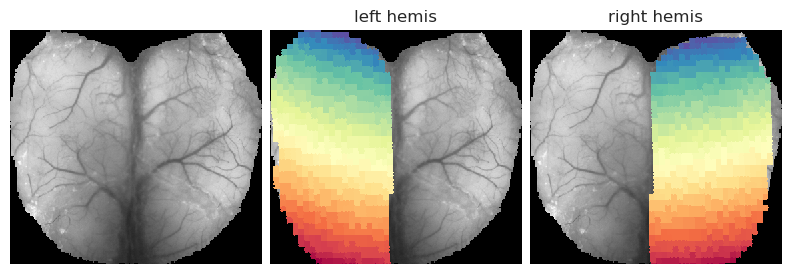

sub 06,  type: ElasticSyN,   mi = 0.5936

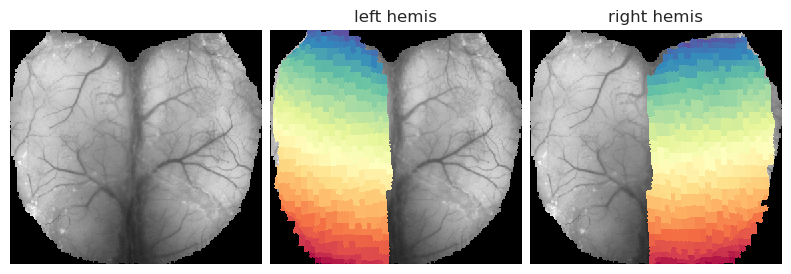

sub 06,  type: SyNAggro,   mi = 0.5932

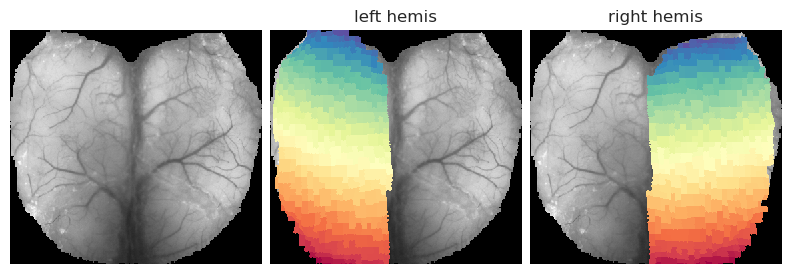

sub 07,  type: Similarity,   mi = 0.5439

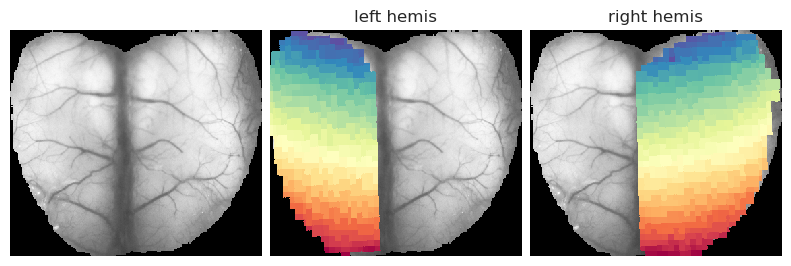

sub 07,  type: Affine,   mi = 0.5442

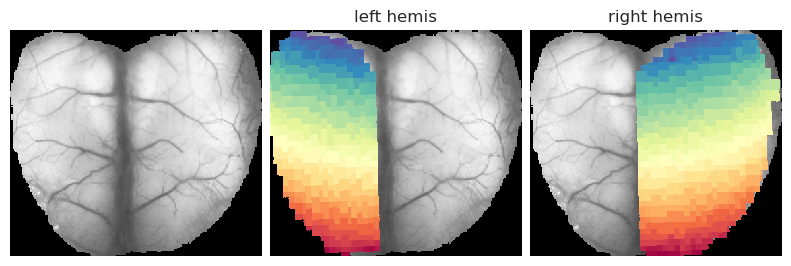

sub 07,  type: ElasticSyN,   mi = 0.5745

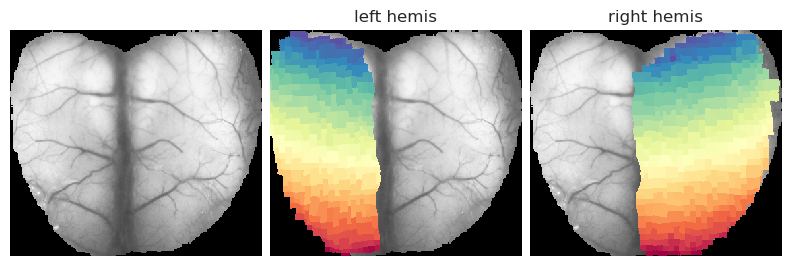

sub 07,  type: SyNAggro,   mi = 0.5737

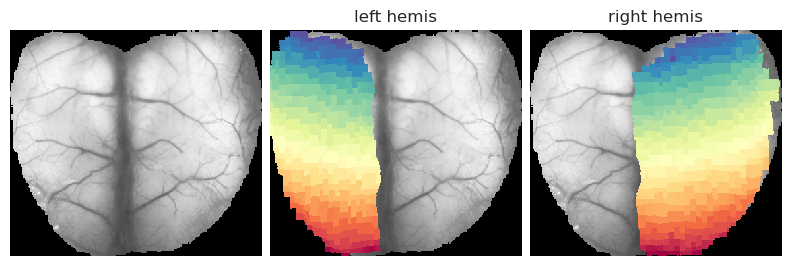

sub 09,  type: Similarity,   mi = 0.6221

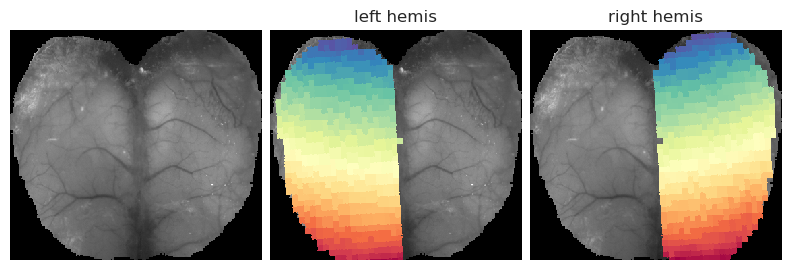

sub 09,  type: Affine,   mi = 0.6221

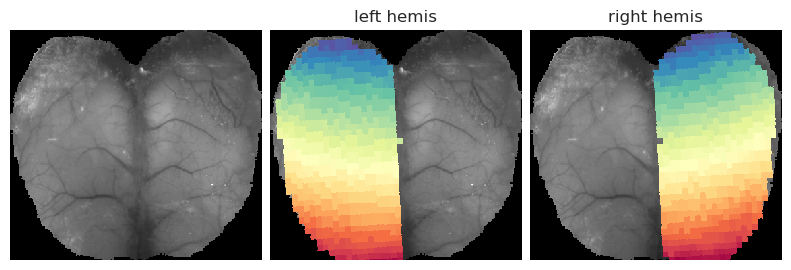

sub 09,  type: ElasticSyN,   mi = 0.6282

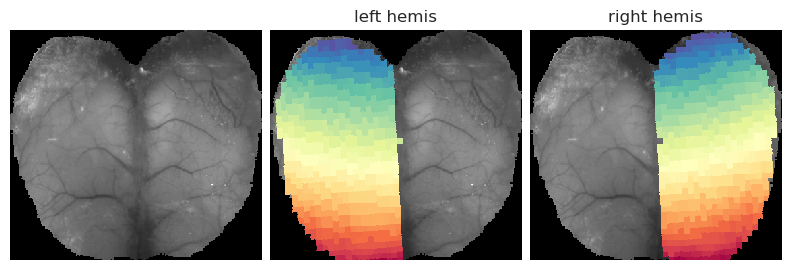

sub 09,  type: SyNAggro,   mi = 0.6281

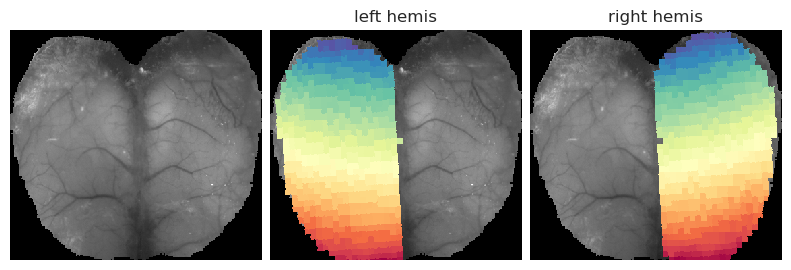

sub 10,  type: Similarity,   mi = 0.6266

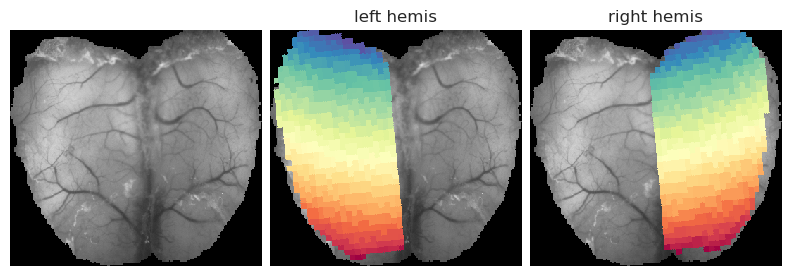

sub 10,  type: Affine,   mi = 0.6267

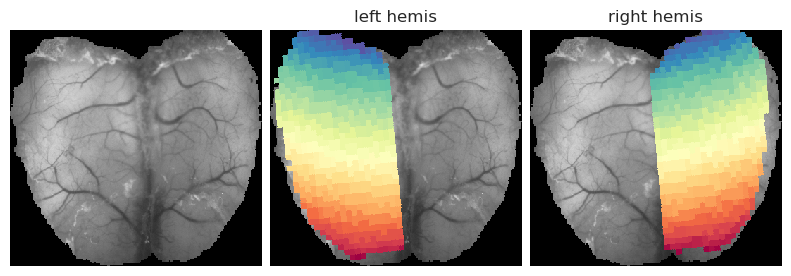

sub 10,  type: ElasticSyN,   mi = 0.6465

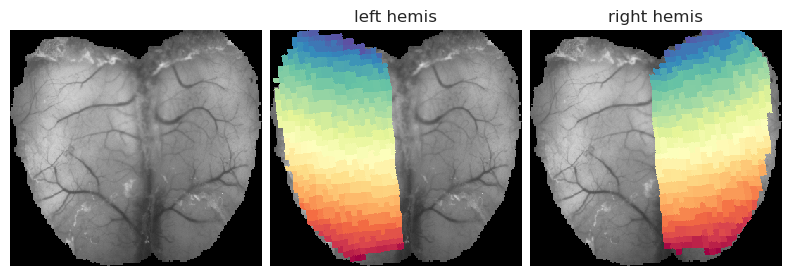

sub 10,  type: SyNAggro,   mi = 0.6464

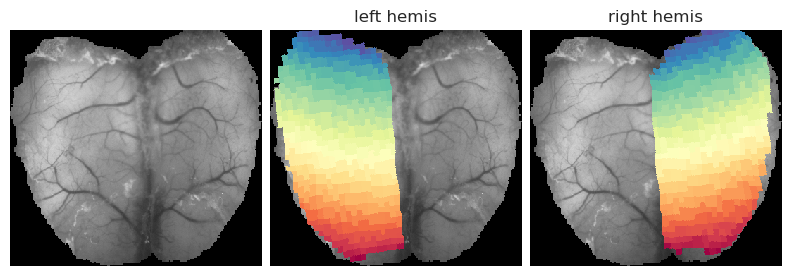

In [36]:
for sub, d in cols_aff.items():
    fx, m_fx = _load_fx(sub)
    for t_type, x in d.items():
        mi = df.loc[
            (df['sub'] == sub) &
            (df['t_type'] == t_type),
            'mi',
        ].values.item()
        print(f"sub {sub:02d},  type: {t_type},   mi = {mi:0.4f}")
        _show_ref_overlay(fx, m_fx, x)